<a href="https://colab.research.google.com/github/Rocyan4/Data_science/blob/master/anomaly_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Análise anomalias utilizando aprendizado não supervisionado


# 1. Qual o problema do caso?
Todos os negócios estão sujeitos à fraudes, busca-se garantir segurança para os clientes e a implementação de um sistema eficaz é de grande importancia para evitar problemas com os clientes.

O grande **objetivo** desse caso é idenficar padrões e características de possíveis fraudes no processo de transação e garantir segurança para o cliente, isso será feito avaliando as variáveis que tiverem maior influência na probabilidade de fraude. 


# 2. Análise exploratória

Primeiro passo é entender cada variável utilizada, alguns pontos são importantes em todo processo de transformação dos dados, tais como, os dados ausentes, tipo de distribuição e a classificação desses dados.

**account_id**: número de identificação do cliente

**operation_type**: Tipo de transação realizada pelo cliente

**amount**: Valor da Transação

**processed_at**: Data em que a transação foi realizada


##Importando as bibliotecas a serem usadas

In [2]:
pip install pyod 

     |████████████████████████████████| 102kB 4.5MB/s 
     |████████████████████████████████| 2.1MB 8.6MB/s 
  Created wheel for pyod: filename=pyod-0.8.6-cp36-none-any.whl size=112146 sha256=34254727bb64d4b4fda4943c7855b0b3f4b93bba448e64cddc5011006f15f379
  Stored in directory: /root/.cache/pip/wheels/48/95/81/2c6f52c3d366e7b5ef4770550f8bf0764257c66fbe64deecdb
  Created wheel for combo: filename=combo-0.1.2-cp36-none-any.whl size=42028 sha256=f723145079407d0b9ca1638e28207521f43a682ea9b2ee7e0abce0c80b4819e2
  Stored in directory: /root/.cache/pip/wheels/01/d9/bf/d1a371a5f0844cd8a53c04c14daa89974c93f429dda9dceb86
  Created wheel for suod: filename=suod-0.0.6-cp36-none-any.whl size=2154759 sha256=5247cee886669263679bcbd515006f88d2eb52895fd8b7a159748b7e852fc7f6
  Stored in directory: /root/.cache/pip/wheels/c5/d7/c1/6c778aee7fccfe3c054ea9bab92c5994ae3a0f6bba7078541e
Successfully built pyod combo suod


In [3]:
pip install plotly --upgrade

     |████████████████████████████████| 13.2MB 307kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [4]:
%matplotlib inline


In [5]:
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


In [6]:
import math

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import plotly.express as px



import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib

plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib import pyplot


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

import seaborn as sns

from sklearn.ensemble import IsolationForest

pd.options.mode.chained_assignment = None


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv("/content/drive/MyDrive/data_science_challenge_dataset/processed_unlabeled_transactions.csv",  delimiter=',', low_memory=False)

In [9]:
df.head()

operation_id  ...                processed_at
0  f9eb1bfc-dd3e-4494-ad3a-5728059a334b  ...  2018-07-15 00:00:25.000000
1  98b084a3-353a-4ea4-8cb6-3a2b48f24d9b  ...  2018-07-15 00:20:32.000000
2  b04d0b3b-620f-4031-8598-14862d8385a4  ...  2018-09-01 23:51:38.000000
3  aa253da4-d86f-45fe-a30c-1e25aa752344  ...  2018-09-13 00:50:27.000000
4  ffed5732-c135-495f-9b43-52f4dbdd0fab  ...  2018-09-22 23:50:38.000000

[5 rows x 9 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087054 entries, 0 to 5087053
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   operation_id           object 
 1   request_id             object 
 2   account_id             object 
 3   device_id              object 
 4   counterparty_document  object 
 5   operation_type         object 
 6   amount                 float64
 7   requested_at           object 
 8   processed_at           object 
dtypes: float64(1), object(8)
memory usage: 349.3+ MB


##3. Tratamento dos Dados
Para evitarmos excesso de dados e não ocorrer um "overfitting" no modelo serão dispensadas as colunas nos quais não serão essenciais para o resultado.


In [11]:
df_ =  df.drop(['request_id','device_id','counterparty_document','requested_at','operation_id'], axis=1)
df_.head()

account_id  ...                processed_at
0  d24e533e-d54f-4ac5-874f-097f968c8b23  ...  2018-07-15 00:00:25.000000
1  d24e533e-d54f-4ac5-874f-097f968c8b23  ...  2018-07-15 00:20:32.000000
2  d24e533e-d54f-4ac5-874f-097f968c8b23  ...  2018-09-01 23:51:38.000000
3  d24e533e-d54f-4ac5-874f-097f968c8b23  ...  2018-09-13 00:50:27.000000
4  d24e533e-d54f-4ac5-874f-097f968c8b23  ...  2018-09-22 23:50:38.000000

[5 rows x 4 columns]

A biblioteca pandas reconhece coluna processed_at como um objeto então foi necessario converter a coluna para datetime se não ocorrerá erros mais pra frente



In [12]:
df_.dtypes

account_id         object
operation_type     object
amount            float64
processed_at       object
dtype: object

In [13]:
df_['Date'] = pd.to_datetime(df_['processed_at'])
df_['Date'] = df_.Date.dt.date
df_['processed_at'] = pd.to_datetime(df_['processed_at'])

In [14]:
df_.describe()

amount
count  5.086699e+06
mean   6.174446e-06
std    1.235077e-04
min    0.000000e+00
25%    4.354140e-07
50%    1.179128e-06
75%    3.343416e-06
max    6.758129e-02

Identificando os valores ausentes e preenchendo com o valor 0

In [15]:
df_.isnull().sum()

account_id          0
operation_type      0
amount            355
processed_at        0
Date                0
dtype: int64

In [16]:
df_ = df_.fillna(0)

Ao plotarmos um boxplot podemos notar alguns outliers no valor montante

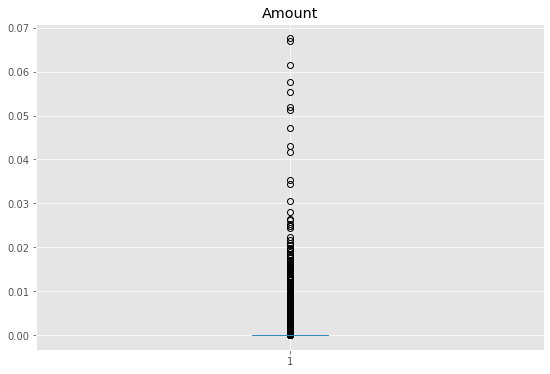

In [17]:
x = df.operation_type.value_counts().index
y = df.operation_type.value_counts().values

f = plt.figure(1,figsize=(20,6))
z = df.amount.value_counts().index
ax2 = f.add_subplot(1,2,1)
ax2.title.set_text('Amount')
_ = ax2.boxplot(z)

## Isolation Forest

**Como funciona o Isolation Forest?**
O modelo de machine learning não supervisionado Iforest funciona baseado no algoritimo de árvores de decisão, isolando os outliers de forma aleatória e selecionando características dadas ao modelo, após isso seleciona um valor entre o máximo e o mínimo dessas características

A **Principal** vantagem de sua utilização, além de identificar anomalias de forma rápida e eficiênte também utiliza uma quantidade menor de memória comparado a outros algoritmos 

O modelo ira gerar a coluna 'y_pred' onde mostrará com os valores 0 e 1 se é uma anomalia ou não.

**1:** Anomalia
**0:** Normal

A outra coluna criada pelo modelo 'y_scores' quanto maior o score da coluna **maior **a probabilidade de ser classificada como anomalia

In [18]:
anomaly_proportion = 0.009

clf_name = 'Anomaly Detection - Isolation Forest'
clf = IForest(contamination=anomaly_proportion)

X = df_[['amount']]
clf.fit(X)

# Criando colunas preditivas e os scores 
df_['y_pred'] = clf.labels_ 
df_['y_scores'] = clf.decision_scores_ 

In [19]:
normal = df_[df_.y_pred == 0]
fraud = df_[df_.y_pred == 1]


In [20]:
print('numero total de outliers',len(fraud)/len(normal))
print('numero total de transações classificadas como normais:',len(normal))
print('numero total de classificadas como anomalias:',len(fraud))

numero total de outliers 0.009058820145654418
numero total de transações classificadas como normais: 5041385
numero total de classificadas como anomalias: 45669


In [21]:
fraud.operation_type.value_counts()

cash_out_type_2    22313
cash_in_type_2      9650
cash_in_type_4      5475
cash_in_type_3      2594
cash_out_type_3     2271
cash_in_type_1      2047
cash_out_type_1     1299
cash_out_type_4       20
Name: operation_type, dtype: int64

##Quais os tipos de operaçoes com maior ocorrência em anomalias?


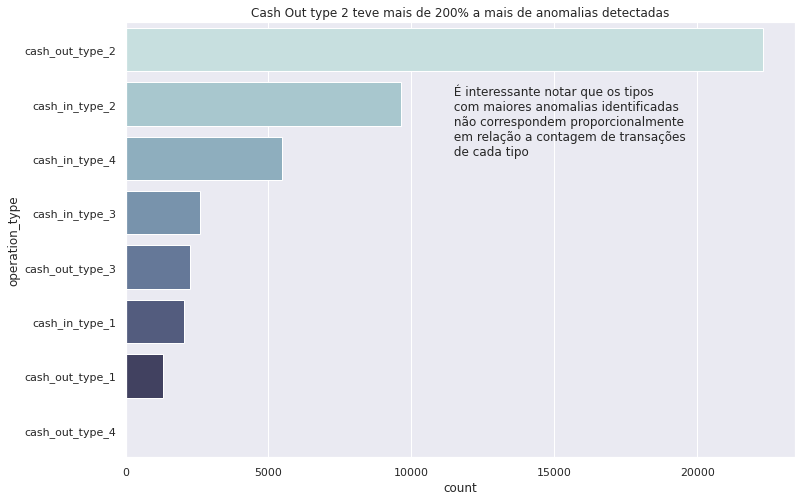

In [66]:
plot =sns.countplot(y='operation_type', data=fraud,order=fraud.operation_type.value_counts().index, palette="ch:start=.2,rot=-.3");
plot.figure.text(0.5, 0.65
                 ,' É interessante notar que os tipos\n com maiores anomalias identificadas\n não correspondem proporcionalmente\n em relação a contagem de transações\n de cada tipo ',fontsize=12);
plot.set_title('Cash Out type 2 teve mais de 200% a mais de anomalias detectadas');



## Quais foram os 10 ID com maior números de transações classificadas como anomalias?

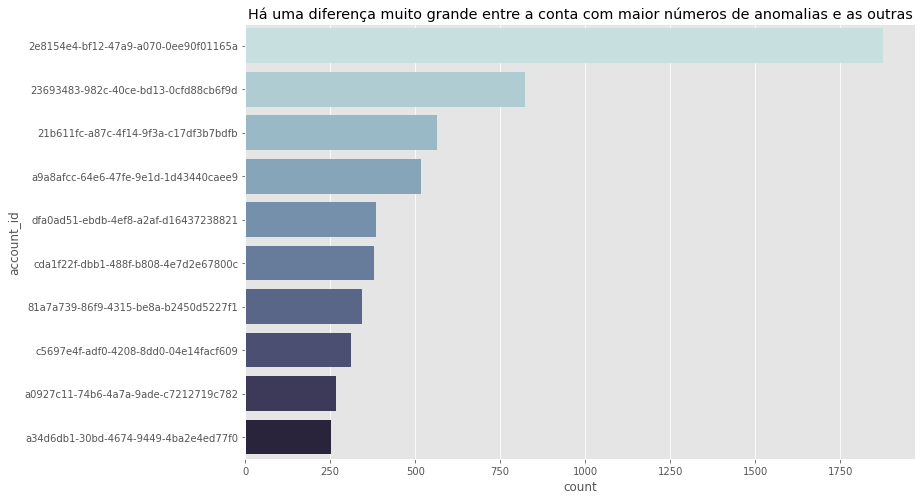

In [23]:
sns.countplot(y='account_id', data=fraud,order=fraud.account_id.value_counts().head(10).index, palette="ch:start=.2,rot=-.3").set_title('Há uma diferença muito grande entre a conta com maior números de anomalias e as outras');

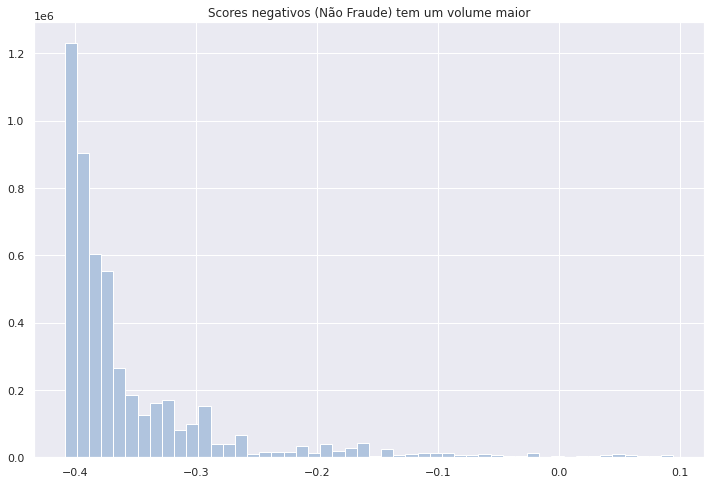

In [24]:
sns.set();
plt.hist(df_.y_scores, color='lightsteelblue',bins=50);
plt.title('Scores negativos (Não Fraude) tem um volume maior');
plt.show();


In [25]:
df_ = df_.sort_values(by=['account_id', 'processed_at']).set_index('processed_at')


## Criando novas colunas para identificarmos novas features

In [27]:
df_['sum_30days'] = df_.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).sum())
df_['count_30days'] = df_.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).count())


In [28]:
df_['avg_30d'] = df_.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).mean())


In [61]:
df_['weekday'] = df_.apply(lambda row: row.name.weekday(), axis=1)
df_['day'] = df_.apply(lambda row: row.name.day,  axis=1)


In [62]:
normal = df_[df_.y_pred == 0]
fraud = df_[df_.y_pred == 1]


In [65]:
print('Número total de outliers',len(fraud_d)/len(normal_d))
print('Número total de operações classificadas como normais:',len(normal_d))
print('Número total de operações classificadas como anomalias:',len(fraud_d))

Número total de outliers 0.009031840307238869
Número total de operações classificadas como normais: 89572
Número total de operações classificadas como anomalias: 809


##Quais os dias ocorrem mais operações fraudulentas?

In [63]:
fraud.weekday.value_counts()

0    15288
2     8060
1     7857
4     7313
3     7052
5       65
6       34
Name: weekday, dtype: int64

##Relação entre anomalias e as datas de occorrência

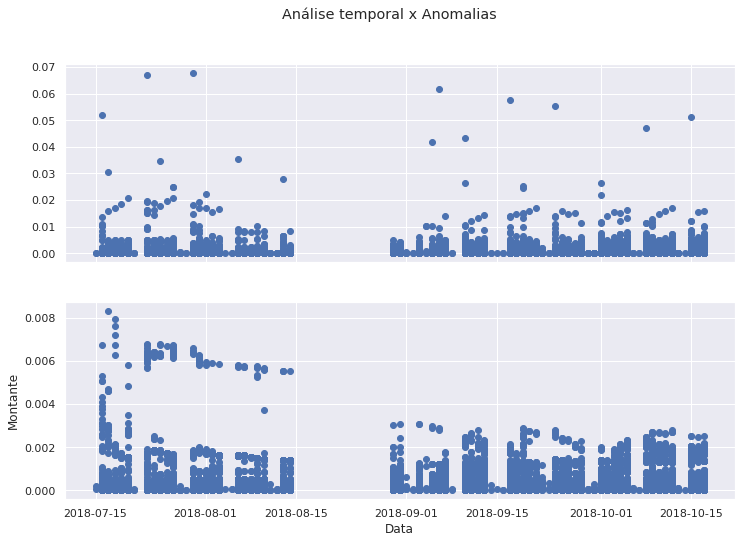

In [32]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
f.suptitle('Análise temporal x Anomalias')

ax1.scatter( fraud.Date,fraud.amount)

ax2.scatter(fraud.Date, fraud.avg_30d)
plt.xlabel('Data')
plt.ylabel('Montante')
plt.show()


In [64]:
g= px.scatter(fraud.reset_index(), x='processed_at', y='avg_30d', color='y_pred', hover_data=['y_pred'], title='Valores das fraudes em relação ao tempo e a média dos ultimos 30 dias')

g.show()

In [34]:
df.fillna(0)
inplace=True

In [36]:
df =  df.drop(['request_id','device_id','counterparty_document','requested_at','operation_id'], axis=1)


KeyError: ignored

In [37]:
df['Date'] = pd.to_datetime(df['processed_at'])
df['Date'] = df.Date.dt.date
df['processed_at'] = pd.to_datetime(df['processed_at'])

##Análise de anomalias no tipo de operação com maior ocorrência 

In [38]:
df_type = df.query('operation_type == "cash_in_type_2"').sort_values(by=['account_id', 'processed_at']).set_index('processed_at')

df_type.head()

account_id  ...        Date
processed_at                                                      ...            
2018-07-30 14:08:05.804559  000892ac-de56-420d-9788-6af728dbd878  ...  2018-07-30
2018-09-28 13:36:58.729020  000892ac-de56-420d-9788-6af728dbd878  ...  2018-09-28
2018-09-24 13:46:07.645319  000bcb33-9502-4c2b-aa13-3449823d3d25  ...  2018-09-24
2018-10-01 11:39:47.245914  000bcb33-9502-4c2b-aa13-3449823d3d25  ...  2018-10-01
2018-10-01 12:00:27.074779  000bcb33-9502-4c2b-aa13-3449823d3d25  ...  2018-10-01

[5 rows x 4 columns]

In [40]:
df_type['avg_30d'] = df_type.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).mean())
df_type['avg_7d'] = df_type.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=7)).mean())


In [41]:
df_type['sum_30days'] = df_type.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).sum())
df_type['count_30days'] = df_type.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=30)).count())



In [42]:
df_type.count_30days.sum()

973136.0

In [43]:
anomaly_proportion = 0.009

clf_name = 'Anomaly Detection - Isolation Forest'
clf = IForest(contamination=anomaly_proportion)

X = df_type[['amount','count_30days', 'sum_30days','avg_30d','avg_7d']]
clf.fit(X)

# Criando colunas preditivas e os scores 
df_type['y_pred'] = clf.labels_ 
df_type['y_scores'] = clf.decision_scores_ 

In [57]:
normal_d = df_type[df_type.y_pred == 0]
fraud_d = df_type[df_type.y_pred == 1]

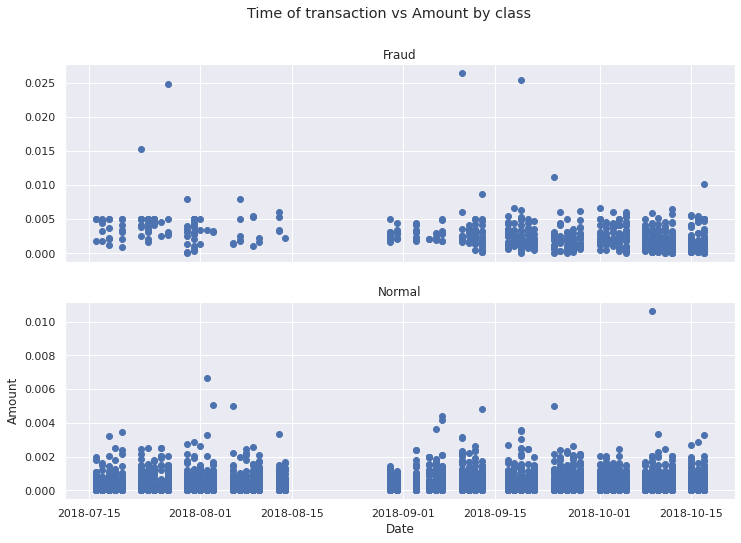

In [46]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud_d.Date, fraud_d.amount)
ax1.set_title('Fraud')

ax2.scatter(normal_d.Date, normal_d.amount)
ax2.set_title('Normal')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.show()


In [47]:
df_type.y_pred.value_counts()

0    89572
1      809
Name: y_pred, dtype: int64

In [50]:
df_type['weekday'] = df_type.apply(lambda row: row.name.weekday(), axis=1)
df_type['day'] = df_type.apply(lambda row: row.name.day,  axis=1)

df_type.dropna(inplace=True)

In [52]:
fig = px.scatter(df_type.reset_index(), x='processed_at', y='avg_30d', color='y_pred', hover_data=['y_pred'], title='Valores outliners em relação ao tempo e a média dos ultimos 30 dias')

fig.show()

In [60]:
fraud_d.weekday.value_counts()

2    177
1    172
0    168
3    155
4    137
Name: weekday, dtype: int64

##Conclusão


O modelo indentifica anomalias de forma rápida e eficaz, há anomalias com valor baixo porém com uma grande quantidade de ocorrência, o que pode ser o caso de lavagem de dinheiro.

A criação de novas features como a média dos últimos dias facilitam a visualizar essas anomalias
